In [1]:
import sys, torch, os
print(f"pytorch version: {torch.__version__}")
import torch.nn.functional as F
import numpy as np

module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

trained_weights_path = './model_weights/gnn/1718175257362/graph_based_detector.pt'
config_file_path = './configuration_radarscenes_gnn.yml'

from modules.set_configurations.set_config_gnn import config
from modules.data_utils.read_data import get_train_val_sequence_names
from modules.set_configurations.set_param_for_inference_gnn import set_parameters_for_inference
from modules.data_utils.read_data import get_sequence_data
from modules.data_utils.labels import compute_new_labels_to_id_dict
from modules.data_utils.labels import compute_old_to_new_label_id_map
from modules.data_utils.read_data import extract_frame
from modules.compute_groundtruth.compute_node_labels import compute_ground_truth as compute_ground_truth_node
from modules.compute_groundtruth.compute_edge_labels import compute_ground_truth as compute_ground_truth_edge
from modules.compute_features.graph_features import select_moving_data
from modules.compute_features.graph_features import compute_adjacency_information
from modules.compute_features.graph_features import compute_edge_features
from modules.compute_features.graph_features import compute_node_features
from modules.compute_groundtruth.compute_offsets import unnormalize_gt_offsets

from modules.inference.inference import compute_proposals
from modules.inference.ellipse import compute_cov_ellipse

from modules.plot_utils.compare_plots import compare_pred_gt_class
from modules.plot_utils.compare_plots import compare_pred_gt_offsets
from modules.plot_utils.compare_plots import compare_pred_gt_edge_class
from modules.plot_utils.compare_plots import compare_pred_gt_object_classes

from modules.plot_utils.show_outputs import plot_pred_class
from modules.plot_utils.show_outputs import plot_pred_offsets
from modules.plot_utils.show_outputs import plot_pred_edge_class
from modules.plot_utils.show_outputs import plot_clusters_measurements_and_object_class
from modules.plot_utils.show_outputs import plot_all_outputs

from modules.plot_utils.show_inputs import plot_measurements
from modules.plot_utils.show_inputs import plot_graph

from modules.data_generator.datagen_gnn import compute_node_idx_for_each_cluster

pytorch version: 2.0.1


In [2]:
config_obj = config(config_file_path)
train_sequence_names, validation_sequence_names = get_train_val_sequence_names(dataset_rootdir, config_obj.dataset_path)

print('train sequences')
print(train_sequence_names)
print('validation sequences')
print(validation_sequence_names)

train sequences
['sequence_1', 'sequence_2', 'sequence_3', 'sequence_4', 'sequence_7', 'sequence_8', 'sequence_9', 'sequence_10', 'sequence_11', 'sequence_12', 'sequence_13', 'sequence_15', 'sequence_16', 'sequence_17', 'sequence_18', 'sequence_20', 'sequence_21', 'sequence_22', 'sequence_23', 'sequence_25', 'sequence_26', 'sequence_27', 'sequence_28', 'sequence_29', 'sequence_30', 'sequence_32', 'sequence_33', 'sequence_34', 'sequence_35', 'sequence_36', 'sequence_37', 'sequence_38', 'sequence_39', 'sequence_40', 'sequence_41', 'sequence_43', 'sequence_44', 'sequence_45', 'sequence_46', 'sequence_47', 'sequence_49', 'sequence_50', 'sequence_51', 'sequence_52', 'sequence_54', 'sequence_55', 'sequence_56', 'sequence_57', 'sequence_59', 'sequence_60', 'sequence_61', 'sequence_62', 'sequence_64', 'sequence_65', 'sequence_66', 'sequence_67', 'sequence_69', 'sequence_70', 'sequence_71', 'sequence_72', 'sequence_74', 'sequence_75', 'sequence_76', 'sequence_77', 'sequence_78', 'sequence_80', 

In [4]:
# 'sequence_138', 'sequence_147', 'sequence_108', 'sequence_148'
sequence_name = 'sequence_148' 
eps = 1.0

param_obj = set_parameters_for_inference(module_rootdir, config_obj, trained_weights_path)
device = param_obj['device']
grid = param_obj['grid']
detector = param_obj['detector']
detector.set_param_for_proposal_extraction(eps, compute_adj_mat_from_links=False) 

scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
    = get_sequence_data(dataset_rootdir, config_obj.dataset_path, sequence_name, config_obj.window_size)

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()

detect_object_by_segmentation_output = True

GPU is available. Good to go!


In [5]:
idx = 0

data_dict = extract_frame(
    idx = idx, 
    windowed_data_list = scene_metadata,
    radar_mount_data = radar_mount_data,
    radar_data_all_scenes = radar_data_all_scenes,
    odometry_data_all_scenes = odometry_data_all_scenes,
    reject_outlier = False)

gt_dict_node = compute_ground_truth_node(data_dict, labels_to_id_dict, old_to_new_label_id_map)
data_dict, gt_dict_node = grid.select_meas_within_the_grid(data_dict, gt_dict_node)
data_dict_dyn, node_labels_dict_dyn = select_moving_data(data_dict, gt_dict_node, labels_to_id_dict)
adj_dict_dyn = compute_adjacency_information(data_dict_dyn, config_obj.ball_query_eps_square, config_obj.k_number_nearest_points)

other_features_dyn = np.stack((
    data_dict_dyn['meas_px'], data_dict_dyn['meas_py'], 
    data_dict_dyn['meas_vx'], data_dict_dyn['meas_vy']), axis=-1)
edge_features_dyn = compute_edge_features(data_dict_dyn, adj_dict_dyn['adj_list'])
node_features_dyn = compute_node_features(
    data_dict_dyn, adj_dict_dyn['degree'], 
    include_region_confidence = config_obj.include_region_confidence, 
    min_range = config_obj.grid_min_r, max_range = config_obj.grid_max_r, 
    min_azimuth = config_obj.grid_min_th, max_azimuth = config_obj.grid_max_th)

graph_features = {}
graph_features['other_features_dyn'] = torch.from_numpy(other_features_dyn).to(device).to(torch.float32)
graph_features['edge_features_dyn'] = torch.from_numpy(edge_features_dyn).to(device).to(torch.float32)
graph_features['node_features_dyn'] = torch.from_numpy(node_features_dyn).to(device).to(torch.float32)
graph_features['edge_index_dyn'] = torch.from_numpy(adj_dict_dyn['adj_list'] ).to(device).to(torch.int64)
graph_features['adj_matrix_dyn'] = torch.from_numpy(adj_dict_dyn['adj_matrix'] ).to(device).to(torch.bool)

edge_labels_dyn = compute_ground_truth_edge(data_dict_dyn, adj_dict_dyn['adj_list'], adj_dict_dyn['adj_matrix'])
gt_labels_dyn = node_labels_dict_dyn['class_labels']
gt_offsets_dyn = np.stack([node_labels_dict_dyn['offsetx'], node_labels_dict_dyn['offsety']], axis=-1)

# cluster offsets predictions
cluster_node_idx, cluster_labels = compute_node_idx_for_each_cluster(data_dict_dyn['meas_trackid'], gt_labels_dyn, device)
# node_cls_predictions, node_offsets_predictions, edge_cls_predictions, obj_cls_predictions = detector(
#     node_features = graph_features['node_features_dyn'],
#     edge_features = graph_features['edge_features_dyn'],
#     edge_index = graph_features['edge_index_dyn'],
#     adj_matrix = graph_features['adj_matrix_dyn'],
#     cluster_node_idx = cluster_node_idx )

node_cls_predictions, node_offsets_predictions, edge_cls_predictions, \
obj_cls_predictions, cluster_members_list = detector(
    node_features = graph_features['node_features_dyn'],
    edge_features = graph_features['edge_features_dyn'],
    other_features = graph_features['other_features_dyn'],
    edge_index = graph_features['edge_index_dyn'],
    adj_matrix = graph_features['adj_matrix_dyn'])

cluster_members_list_pred = cluster_members_list
cluster_members_list_gt = cluster_node_idx

# predict cluster centers
reg_deltas = unnormalize_gt_offsets(node_offsets_predictions, config_obj.reg_mu, config_obj.reg_sigma)
pred_cluster_centers_xy = graph_features['other_features_dyn'][:, :2] + reg_deltas

# predict node class
cls_prob = F.softmax(node_cls_predictions, dim=-1)
cls_score, cls_idx = torch.max(cls_prob, dim=-1)

# predict edge class
edge_cls_prob= F.softmax(edge_cls_predictions, dim=-1)
edge_cls_score, edge_cls_idx = torch.max(edge_cls_prob, dim=-1)

# predict object class
if detect_object_by_segmentation_output == True:
    obj_pred_cls_list = []
    for cluster_mem in cluster_members_list_pred:
        cluster_meas_labels = cls_idx[cluster_mem]
        obj_pred_cls_list.append(torch.argmax(torch.bincount(cluster_meas_labels)))
    obj_cls_idx = torch.stack(obj_pred_cls_list, dim=0)

else:
    obj_cls_prob = F.softmax(obj_cls_predictions, dim=-1)
    obj_cls_score, obj_cls_idx = torch.max(obj_cls_prob, dim=-1)

print(f"object class predictions: {obj_cls_idx}")
print(f"object class GT         : {cluster_labels}")

# print(obj_cls_idx.shape)
# print(cluster_labels.shape)

object class predictions: tensor([0, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 4, 0, 4, 6, 6, 6, 6, 6, 6, 0, 6,
        6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
object class GT         : tensor([4, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0')


In [6]:
px = graph_features['other_features_dyn'][:, 0].detach().cpu().numpy()
py = graph_features['other_features_dyn'][:, 1].detach().cpu().numpy()
pred_class = cls_idx.detach().cpu().numpy()
pred_edge_class = edge_cls_idx.detach().cpu().numpy()

pred_cluster_centers_xy = pred_cluster_centers_xy.detach().cpu().numpy()
pred_cluster_centers_x_all = pred_cluster_centers_xy[:,0]
pred_cluster_centers_y_all = pred_cluster_centers_xy[:,1]
gt_cluster_centers_x_all = px + node_labels_dict_dyn['offsetx']
gt_cluster_centers_y_all = py + node_labels_dict_dyn['offsety']

flag = gt_labels_dyn != 6
pred_cluster_centers_x_valid = pred_cluster_centers_x_all[flag]
pred_cluster_centers_y_valid = pred_cluster_centers_y_all[flag]
gt_cluster_centers_x_valid = gt_cluster_centers_x_all[flag]
gt_cluster_centers_y_valid = gt_cluster_centers_y_all[flag]

adj_matrix = graph_features['adj_matrix_dyn']
valid_row_idx, valid_col_idx = torch.nonzero(torch.triu(adj_matrix, diagonal=1), as_tuple=True)
edge_index = torch.stack((valid_row_idx, valid_col_idx), axis=0)
edge_index = edge_index.detach().cpu().numpy()

# -----------------------------------------------------------------------------------------------------
obj_class_pred = obj_cls_idx.detach().cpu().numpy().tolist()
obj_class_gt = cluster_labels.detach().cpu().numpy().tolist()

cluster_mean_list_pred, cluster_cov_list_pred, cluster_size_pred \
    = compute_proposals(cluster_members_list_pred, px, py, detector.meas_noise_cov)

cluster_mean_list_gt, cluster_cov_list_gt, cluster_size_gt \
    = compute_proposals(cluster_members_list_gt, px, py, detector.meas_noise_cov)

cluster_boundary_points_list_pred = []
for mu, cov in zip(cluster_mean_list_pred, cluster_cov_list_pred):
    boundary_points, _ = compute_cov_ellipse(mu, cov, chi_sq = 2, n_points=100)
    cluster_boundary_points_list_pred.append(boundary_points)

cluster_boundary_points_list_gt = []
for mu, cov in zip(cluster_mean_list_gt, cluster_cov_list_gt):
    boundary_points, _ = compute_cov_ellipse(mu, cov, chi_sq = 2, n_points=100)
    cluster_boundary_points_list_gt.append(boundary_points)

### Plot Inputs

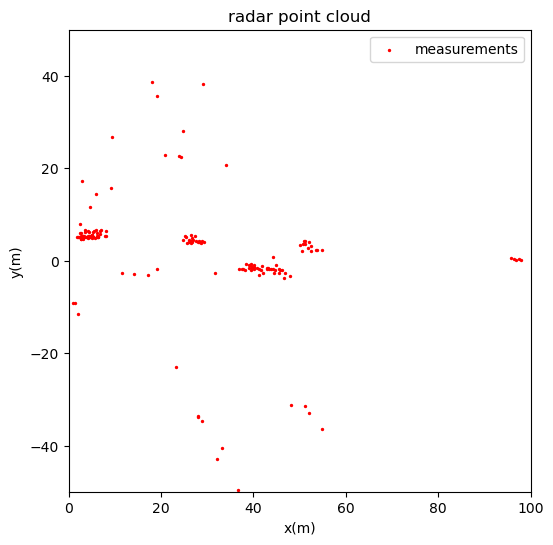

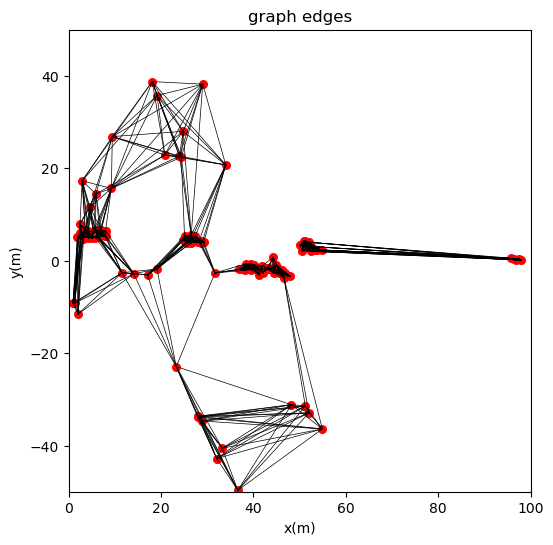

In [7]:
plot_measurements(px, py, size=2, figsize = (6, 6))
plot_graph(px, py, edge_index, figsize = (6, 6))

### Plot predictions

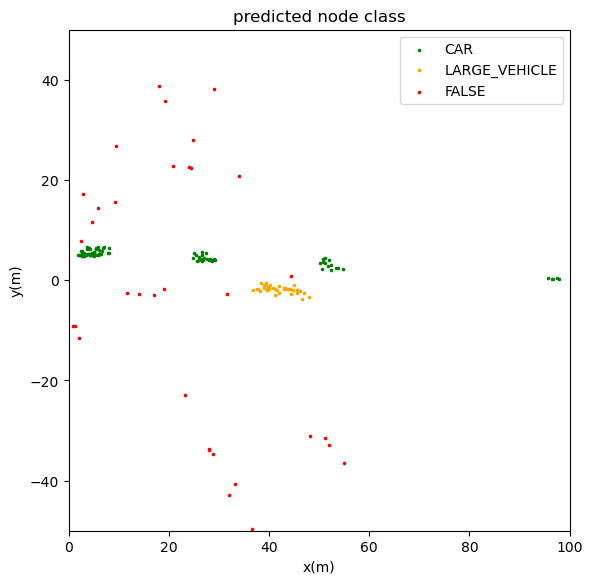

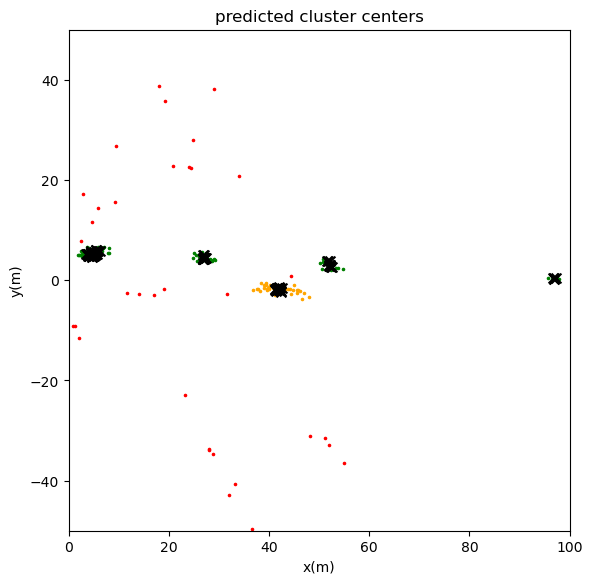

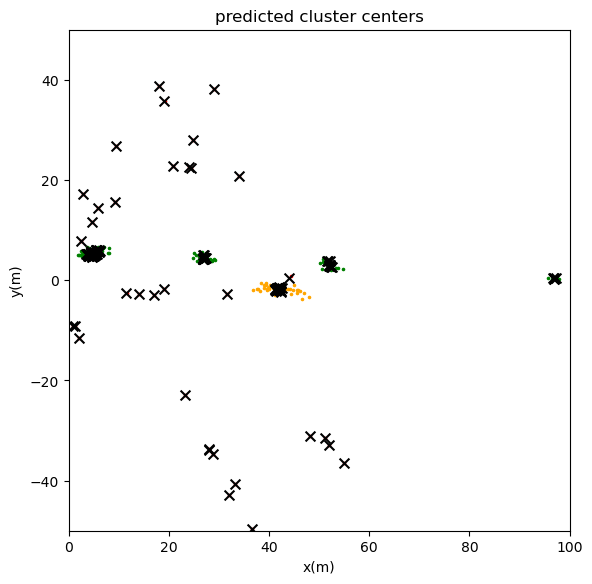

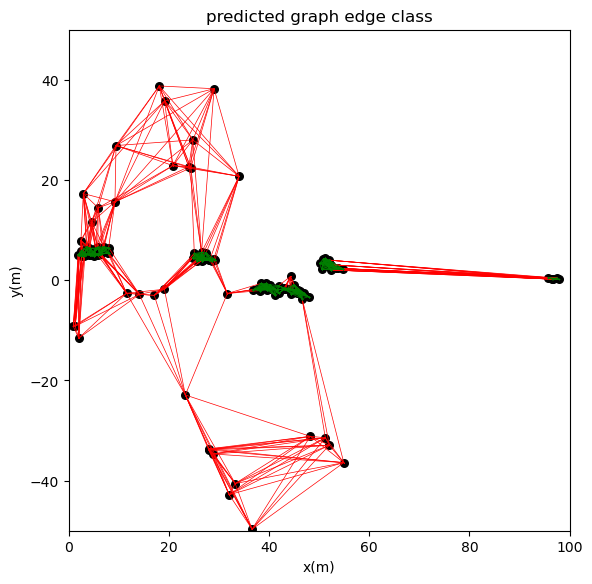

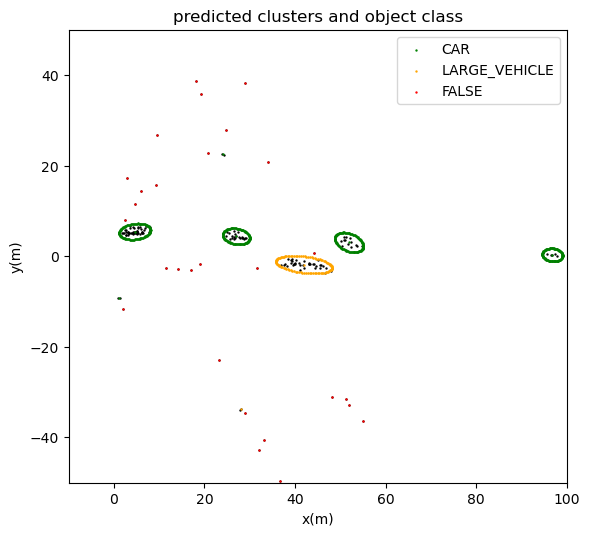

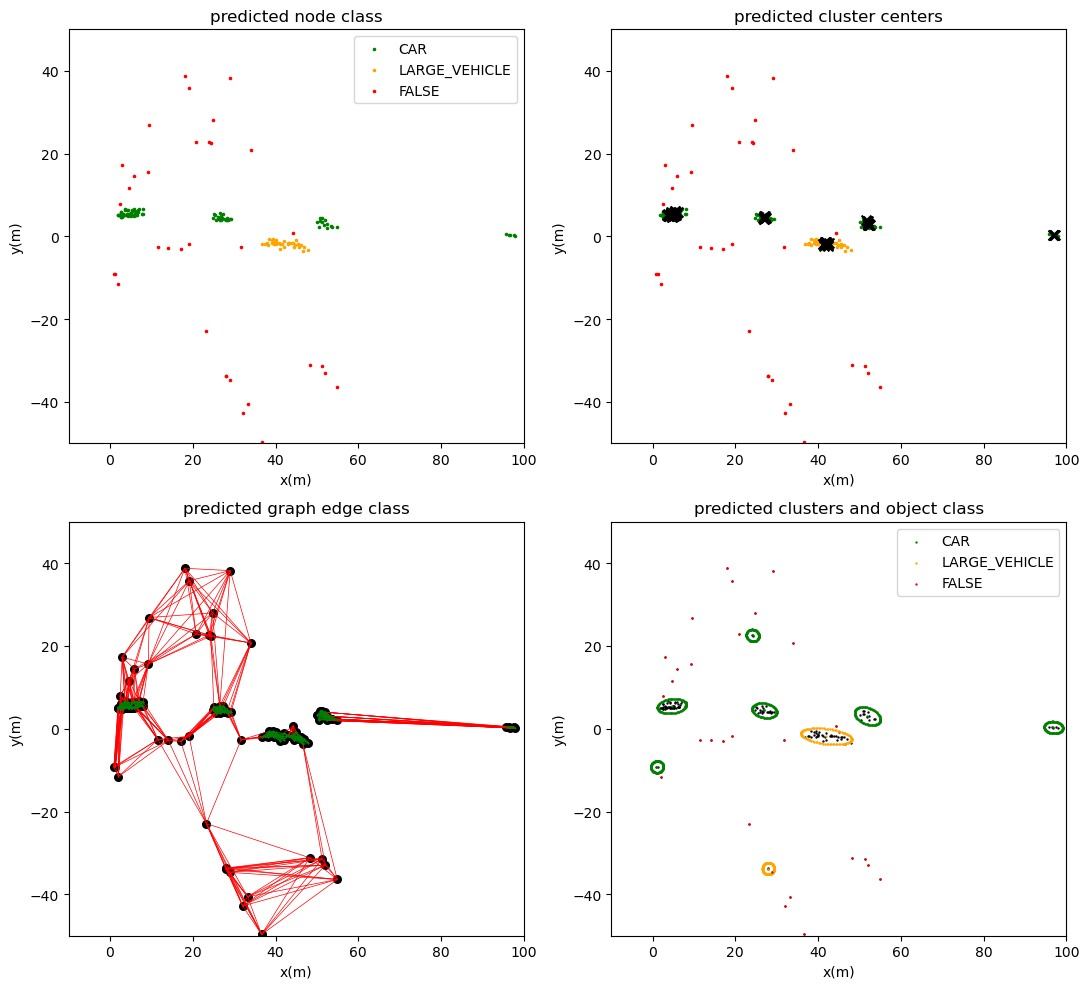

In [8]:
plot_pred_class(
    px, py, 
    pred_class,
    config_obj.object_classes_dyn, 
    figsize = (6, 6))

plot_pred_offsets(
    px, py, 
    pred_cluster_centers_x_valid, pred_cluster_centers_y_valid, pred_class,
    config_obj.object_classes_dyn, 
    figsize = (6, 6))

plot_pred_offsets(
    px, py, 
    pred_cluster_centers_x_all, pred_cluster_centers_y_all, pred_class,
    config_obj.object_classes_dyn, 
    figsize = (6, 6))

plot_pred_edge_class(
    px, py, edge_index,
    pred_edge_class,
    figsize=(6, 6))

plot_clusters_measurements_and_object_class(
    px, py, 
    obj_class_pred,
    cluster_mean_list_pred, 
    cluster_boundary_points_list_pred,
    cluster_size_pred,
    config_obj.object_classes_dyn,
    figsize=(6, 6) )


plot_all_outputs(
    px, py, config_obj.object_classes_dyn,
    pred_class, 
    pred_cluster_centers_x_valid, pred_cluster_centers_y_valid,
    edge_index, pred_edge_class,
    obj_class_pred,
    cluster_mean_list_pred, 
    cluster_boundary_points_list_pred,
    cluster_size_pred,
    cluster_size_threshold = 1,
    figsize=(11,10))

### Compare ground-truth and predictions side by side

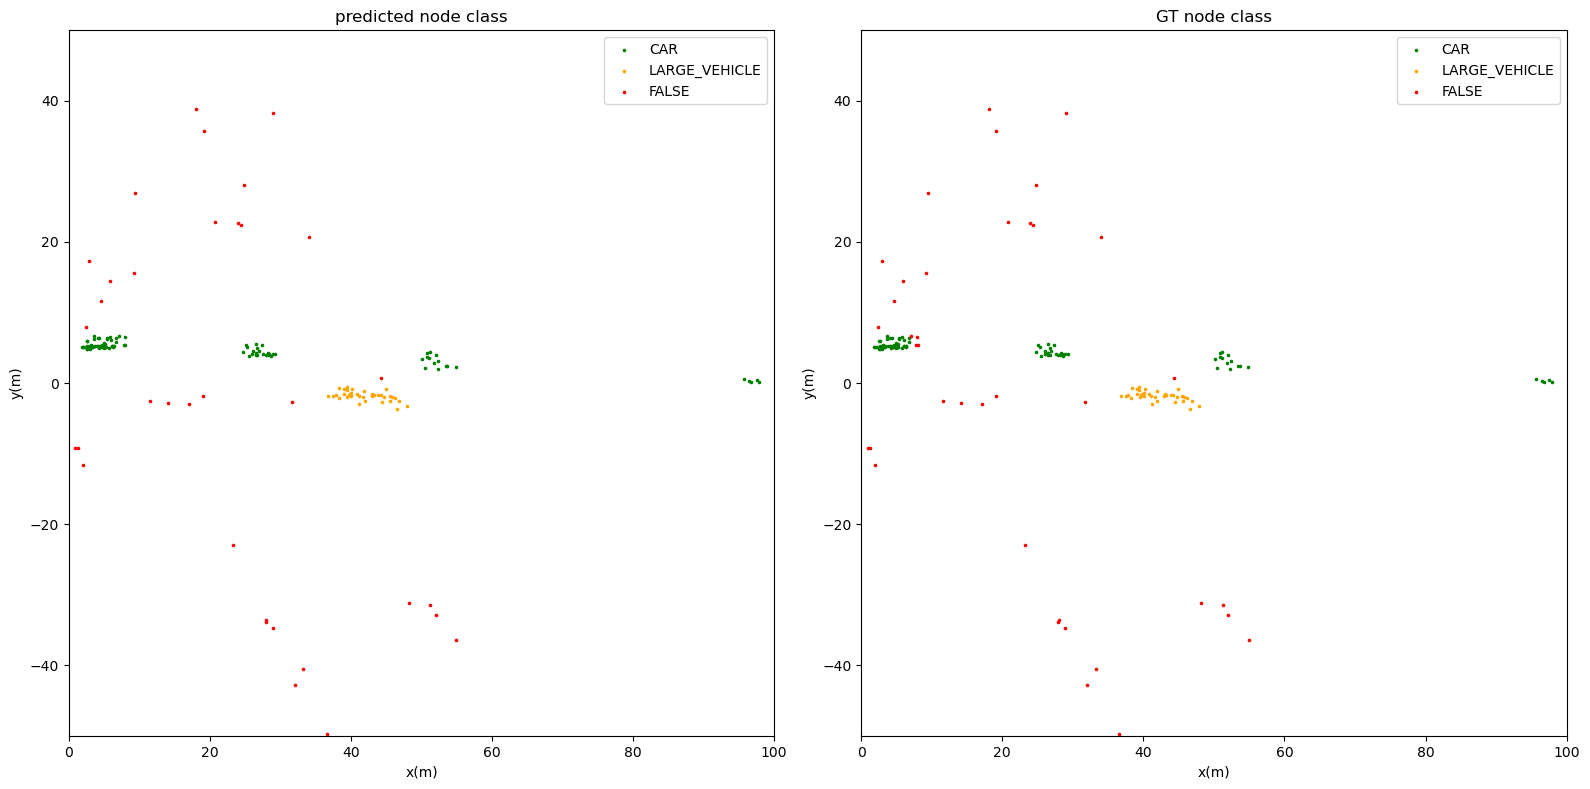

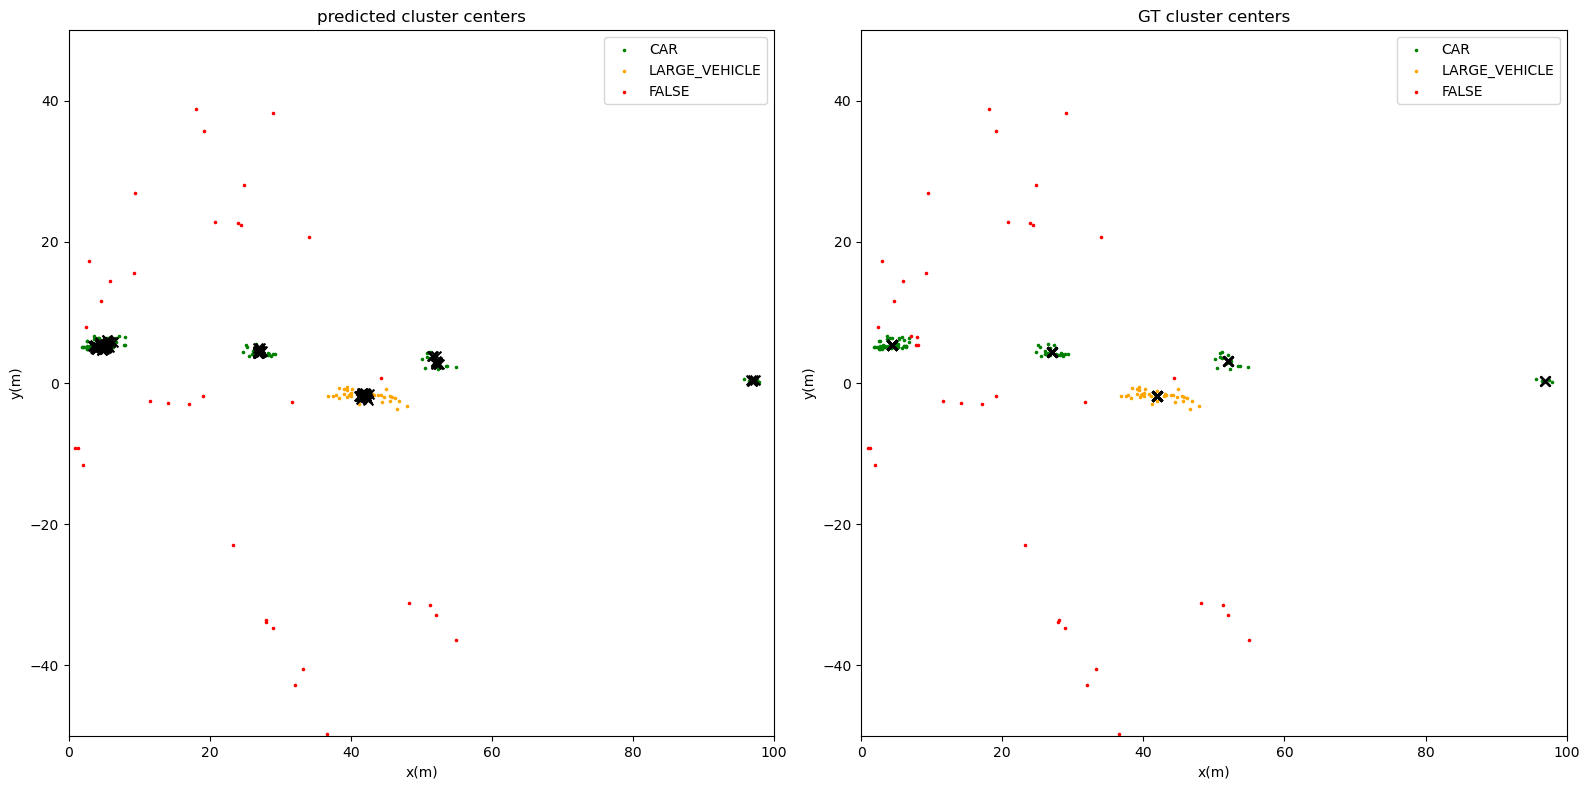

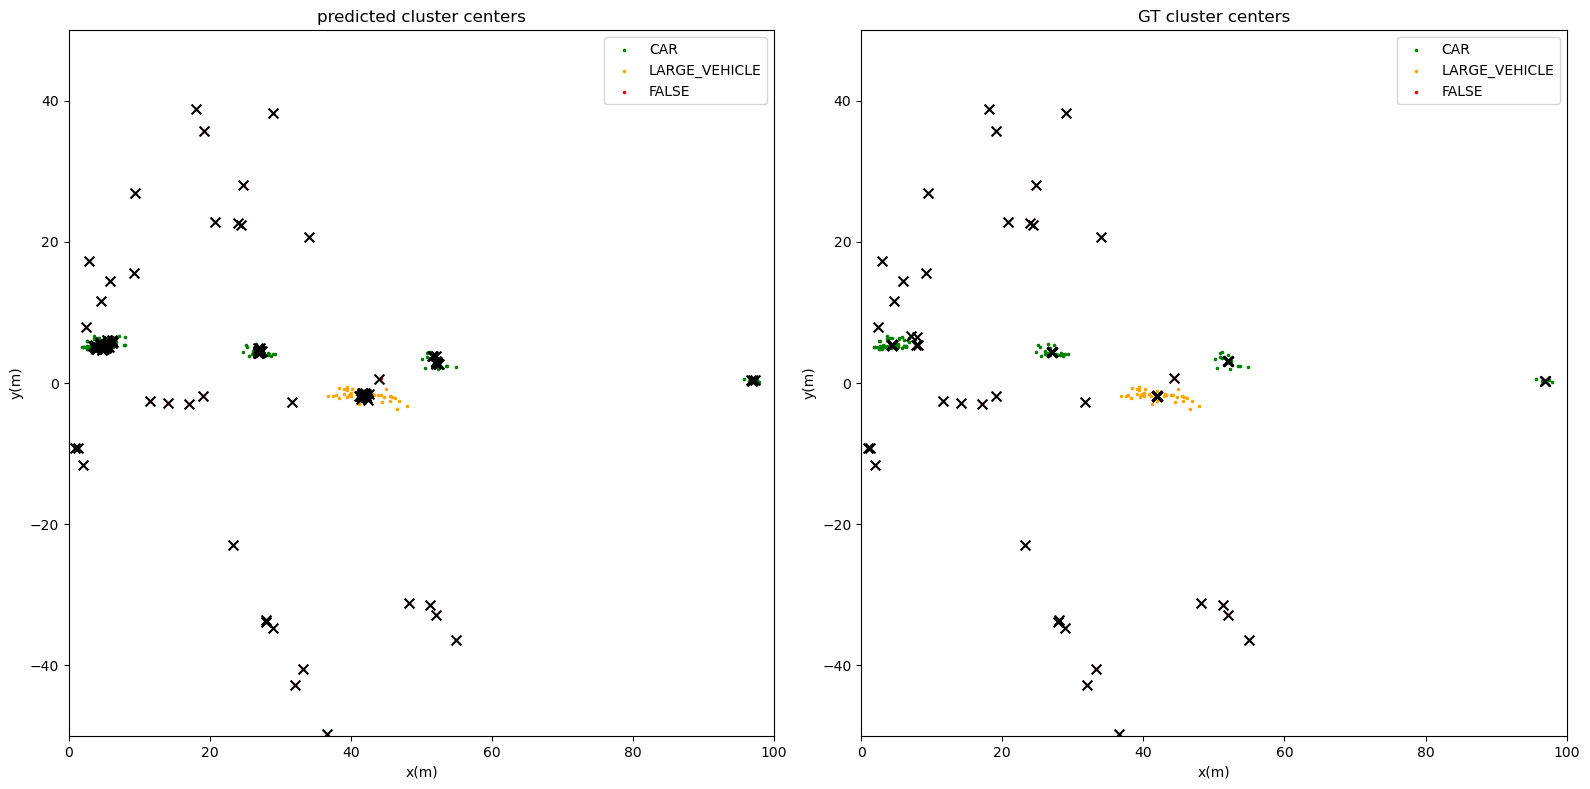

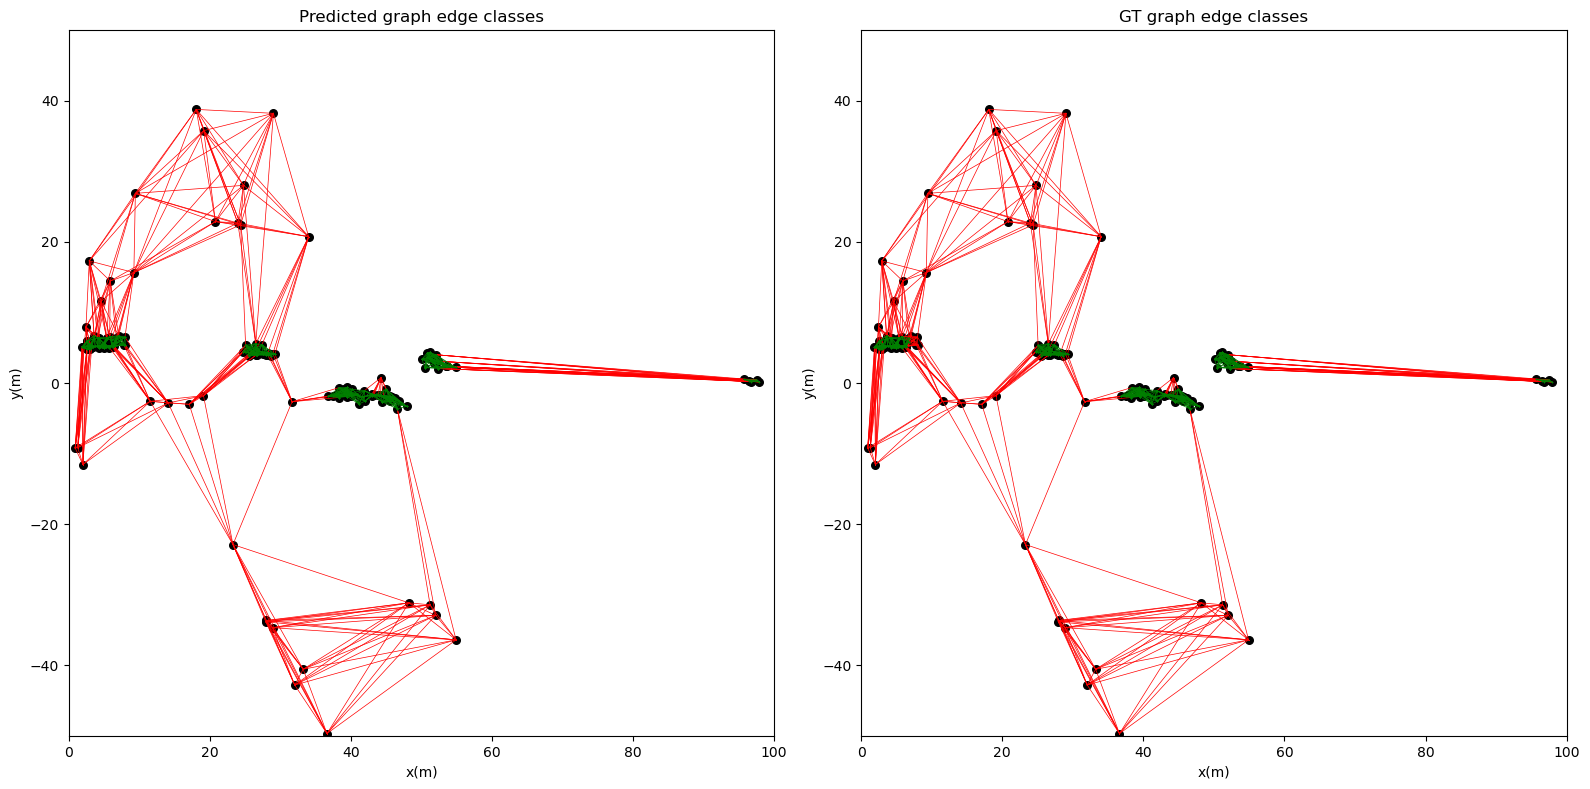

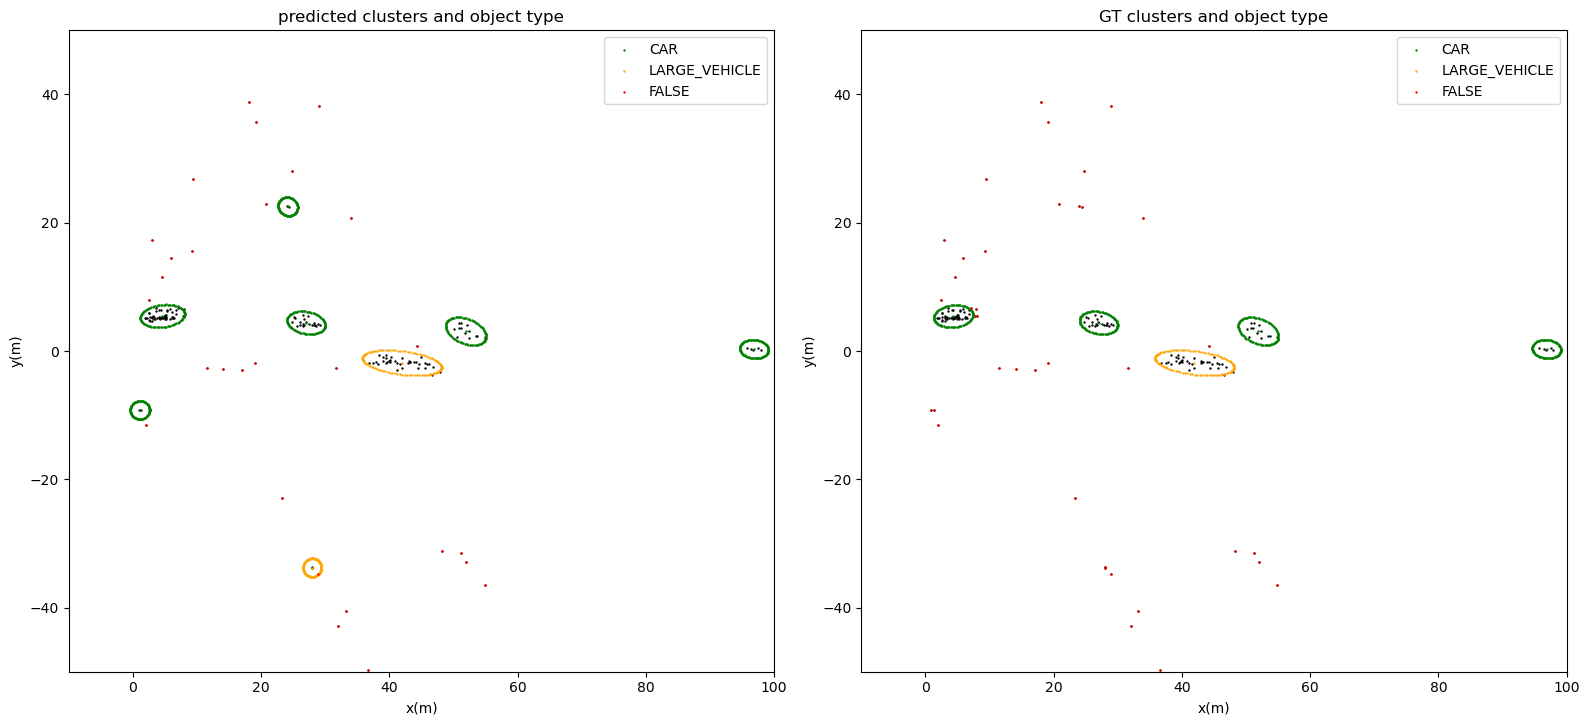

In [9]:
compare_pred_gt_class(
    px, py, 
    pred_class,
    gt_labels_dyn,
    config_obj.object_classes_dyn, 
    figsize = (16, 8))

compare_pred_gt_offsets(
    px, py, 
    pred_cluster_centers_x_valid, pred_cluster_centers_y_valid, pred_class,
    gt_cluster_centers_x_valid, gt_cluster_centers_y_valid, gt_labels_dyn,
    config_obj.object_classes_dyn, 
    figsize = (16, 8))

compare_pred_gt_offsets(
    px, py, 
    pred_cluster_centers_x_all, pred_cluster_centers_y_all, pred_class,
    gt_cluster_centers_x_all, gt_cluster_centers_y_all, gt_labels_dyn,
    config_obj.object_classes_dyn, 
    figsize = (16, 8))

compare_pred_gt_edge_class(
    px, py, edge_index,
    pred_edge_class, edge_labels_dyn,
    figsize=(16, 8))

# plot_edge_labels(
#     px, py, 
#     edge_index, 
#     pred_edge_class, 
#     figsize=(10, 10))

compare_pred_gt_object_classes(
    px, py, 
    obj_class_pred,
    cluster_mean_list_pred, 
    cluster_boundary_points_list_pred,
    cluster_size_pred,
    obj_class_gt,
    cluster_mean_list_gt, 
    cluster_boundary_points_list_gt,
    cluster_size_gt,
    config_obj.object_classes_dyn,
    figsize=(16, 8))